In [19]:
from astropy.io import fits
import numpy as np
import os
import matplotlib.pyplot as plt
from astropy.stats import SigmaClip
from photutils.background import Background2D, SExtractorBackground
from mpl_toolkits.axes_grid1 import make_axes_locatable
from astropy.visualization import LogStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from scipy import ndimage
from scipy.ndimage import gaussian_filter
import little_things_functions as ltf
import cv2
from scipy.optimize import curve_fit
from matplotlib.patches import Ellipse


# DDO 43

## R_25

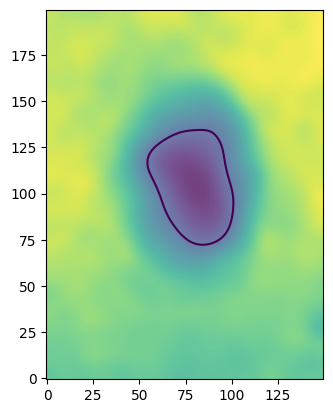

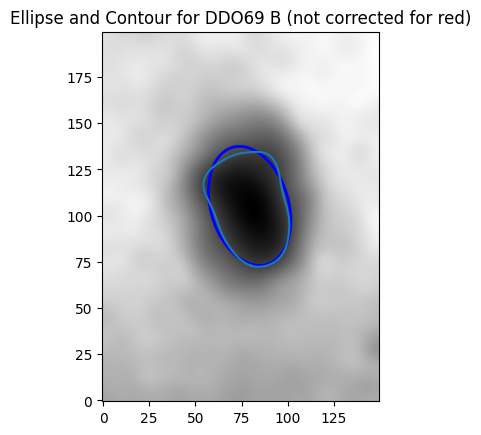

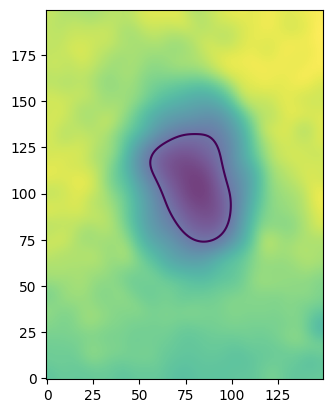

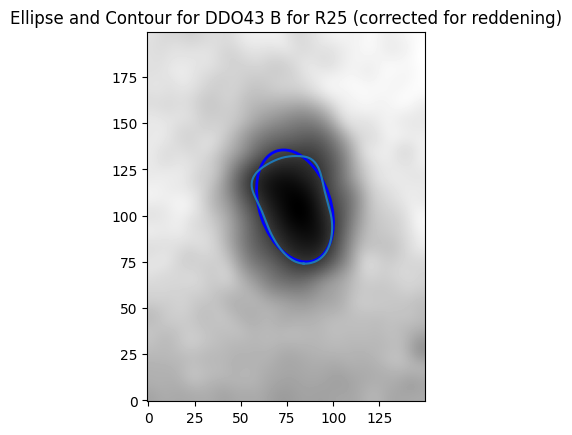

NOT corrected RB 25 for DDO43 is: 0.6367320336526333 kpc
CORRECTED RB 25 for DDO43 is: 0.5818089306713662 kpc
Paper value is 0.98 kpc


In [26]:
starless_file_u = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO43\non_shifted_background_d43u.fits")
starless_u = starless_file_u[0].data

starless_file_b = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO43\non_shifted_background_d43b.fits")
starless_b = starless_file_b[0].data

starless_file_v = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO43\non_shifted_background_d43v.fits")
starless_v = starless_file_v[0].data

DDO43 = [starless_u , starless_b , starless_v]
galaxy_name = "DDO43"
# Constants and parameters
pixel_scale = 1.134
D = 5.5
E_B_V = 0.05
filters = ["U", "B", "V"]
exposures = [1800, 1800, 900]
airmass_values = [1.33, 1.04 ,1.16]
mU_values = [5.251, 0.459, -0.121, 0.]
mV_values = [33.017, 0.137418, 0.045, 0.]
mB_values = [3.445, 0.2522084, -0.022, 0.]
m_values = [mU_values, mB_values, mV_values]

# Crop image to a specific region
box_size_x = 75
box_size_y = 100
box_center = (450, 460)
image_boxes = [DDO43[i][box_center[0] - box_size_y: box_center[0] + box_size_y, box_center[1] - box_size_x: box_center[1] + box_size_x] for i in range(len(DDO43))]

# Magnitude correction
b_box = ltf.mag_table_correction(image_boxes, airmass_values, m_values, pixel_scale, exposures, 5)[1]
v_box = ltf.mag_table_correction(image_boxes, airmass_values, m_values, pixel_scale, exposures, 5)[2]
# Contour coordinates
contour_points = ltf.contour_lines_coordinates(b_box, [25])
x_points, y_points = contour_points
# Center of mass for ellipse fitting

image_center_of_mass = ndimage.center_of_mass(b_box)
x, y = image_center_of_mass[1], image_center_of_mass[0]
initial_guess = [x, y, (max(x_points) - min(x_points)) / 2, (max(y_points) - min(y_points)) / 2, 0]

# Fit ellipse
popt_25, pcov_25 = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
xc, yc, a, b, theta = popt_25

# Plot the image, contour, and ellipse
fig, ax = plt.subplots()
ax.imshow(b_box, cmap='gray', origin='lower')
ax.plot(x_points, y_points)
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(ellipse)
plt.title("Ellipse and Contour for DDO69 B (not corrected for red)")
plt.show()

b_box_corrected = ltf.correct_reddening_B(b_box, E_B_V)
contour_points_c = ltf.contour_lines_coordinates(b_box_corrected, [25])
x_points_c, y_points_c = contour_points_c
# Center of mass for ellipse fitting
image_center_of_mass_c = ndimage.center_of_mass(b_box_corrected)
x, y = image_center_of_mass_c[1], image_center_of_mass_c[0]
initial_guess_c = [x, y, (max(x_points_c) - min(x_points_c)) / 2, (max(y_points_c) - min(y_points_c)) / 2, 0]
# Fit ellipse
popt_25_c, pcov_25_c = curve_fit(ltf.ellipse, (x_points_c, y_points_c), np.zeros_like(x_points_c), p0=initial_guess_c)
xc_c, yc_c, a_c, b_c, theta_c = popt_25_c
# Plot the image, contour, and ellipse (reddening corrected)
fig, ax = plt.subplots()
ax.imshow(b_box_corrected, cmap='gray', origin='lower')
ax.plot(x_points_c, y_points_c)
ellipse_c = Ellipse(xy=(xc, yc), width=2*a_c, height=2*b_c, angle=np.degrees(theta_c), edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(ellipse_c)
plt.title(f"Ellipse and Contour for {galaxy_name} B for R25 (corrected for reddening)")
plt.show() 


# Calculate the physical size
a_25_arcsec = a * pixel_scale
RB_25 = (D * a_25_arcsec) / 206265
print(f"NOT corrected RB 25 for {galaxy_name} is:", RB_25 * 1000, "kpc")
a_25_arcsec_c = a_c * pixel_scale
RB_25_c = (D * a_25_arcsec_c) / 206265
print(f"CORRECTED RB 25 for {galaxy_name} is:", RB_25_c * 1000, "kpc")
print("Paper value is 0.98 kpc")

## R_H

Median of the center box: 30.205615497433673


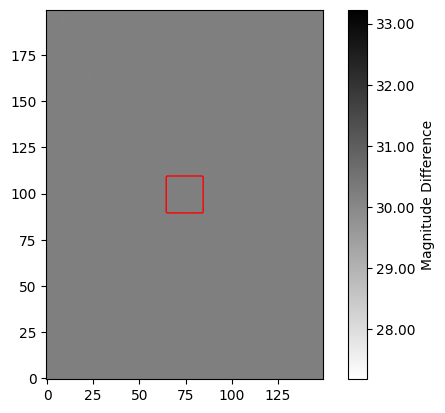

Holmberg mag threshold is 26.72


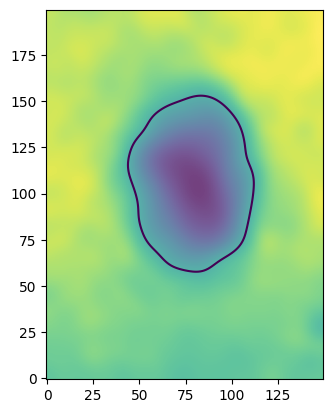

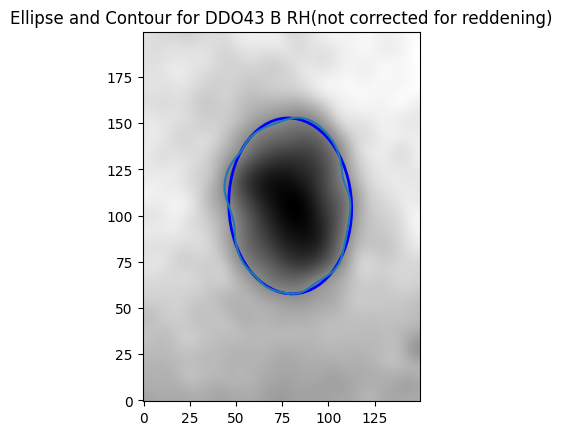

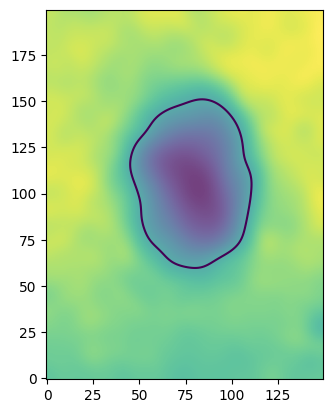

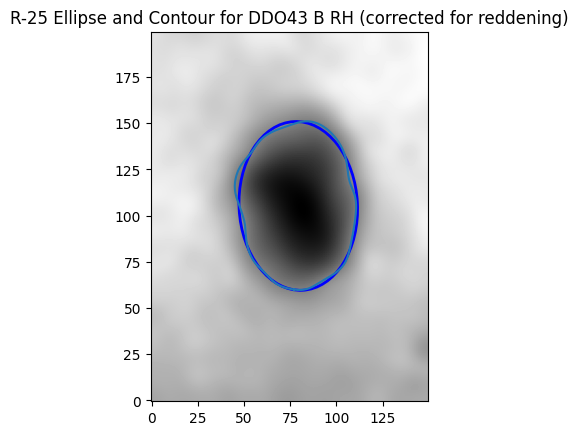

NOT corrected RH for DDO43 is: 1.0042445370325572 kpc
CORRECTED RB 25 for DDO43 is: 0.9688608870491084 kpc
Paper value is 1.42 kpc


In [32]:
B_V_magnitude_table = b_box - v_box - E_B_V

# Get the dimensions of the image
height, width = B_V_magnitude_table.shape

# Calculate the coordinates for the center box
center_x, center_y = width // 2, height // 2
box_size = 20

# Extract the center box
center_box = B_V_magnitude_table[center_y - box_size // 2:center_y + box_size // 2, center_x - box_size // 2:center_x + box_size // 2]

# Calculate the median of the center box
median_center_box = np.nanmedian(center_box)

print("Median of the center box:", median_center_box)

# Plot the image with the box
fig, ax = plt.subplots()
im = ax.imshow(B_V_magnitude_table, origin='lower', cmap='gray_r')  # Use inverted grayscale colormap
cbar = fig.colorbar(im, ax=ax, format='%.2f')
cbar.set_label('Magnitude Difference')

# Add the box to the image
box_mask = np.zeros_like(B_V_magnitude_table, dtype=bool)
box_mask[center_y - box_size // 2:center_y + box_size // 2, center_x - box_size // 2:center_x + box_size // 2] = True
ax.contour(box_mask, colors='red', linewidths=1)
plt.show()

#Holmberg magnitude:
H = float(26.5 + 0.22)
print(f"Holmberg mag threshold is {H}")

# Contour coordinates
contour_points_H = ltf.contour_lines_coordinates(b_box, [H])
x_points_H, y_points_H = contour_points_H
# Center of mass for ellipse fitting
image_center_of_mass = ndimage.center_of_mass(b_box)
x, y = image_center_of_mass[1], image_center_of_mass[0]
initial_guess = [x, y, (max(x_points_H) - min(x_points_H)) / 2, (max(y_points_H) - min(y_points_H)) / 2, 0]
# Fit ellipse
popt_25_H, pcov_25_H = curve_fit(ltf.ellipse, (x_points_H, y_points_H), np.zeros_like(x_points_H), p0=initial_guess)
xc_H, yc_H, a_H, b_H, theta_H = popt_25_H
# Plot the image, contour, and ellipse (not reddening corrected)
fig, ax = plt.subplots()
ax.imshow(b_box, cmap='gray', origin='lower')
ax.plot(x_points_H, y_points_H)
ellipse = Ellipse(xy=(xc, yc), width=2*a_H, height=2*b_H, angle=np.degrees(theta_H), edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(ellipse)
plt.title(f"Ellipse and Contour for {galaxy_name} B RH(not corrected for reddening)")
plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------#
b_box_corrected_H = ltf.correct_reddening_B(b_box, E_B_V)
contour_points_c_H = ltf.contour_lines_coordinates(b_box_corrected_H,[H])
x_points_c_H, y_points_c_H = contour_points_c_H
# Center of mass for ellipse fitting
image_center_of_mass_c = ndimage.center_of_mass(b_box_corrected_H)
x, y = image_center_of_mass_c[1], image_center_of_mass_c[0]
initial_guess_c_H = [x, y, (max(x_points_c_H) - min(x_points_c_H)) / 2, (max(y_points_c_H) - min(y_points_c_H)) / 2, 0]
# Fit ellipse
popt_25_c_H, pcov_25_c_H = curve_fit(ltf.ellipse, (x_points_c_H, y_points_c_H), np.zeros_like(x_points_c_H), p0=initial_guess_c_H)
xc_c_H, yc_c_H, a_c_H, b_c_H, theta_c_H = popt_25_c_H
# Plot the image, contour, and ellipse (reddening corrected)
fig, ax = plt.subplots()
ax.imshow(b_box_corrected_H, cmap='gray', origin='lower')
cax = ax.imshow(b_box_corrected_H, cmap='gray', origin='lower')
ax.plot(x_points_c_H, y_points_c_H)
ellipse_c_H = Ellipse(xy=(xc, yc), width=2*a_c_H, height=2*b_c_H, angle=np.degrees(theta_c_H), edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(ellipse_c_H)
plt.title(f"R-25 Ellipse and Contour for {galaxy_name} B RH (corrected for reddening)")
plt.show() 

#-------------------------------------------------------------------------------------------------------------------------------------------------#
# Calculate the physical size
a_25_arcsec_H = a_H * pixel_scale
RH = (D * a_25_arcsec_H) / 206265
print(f"NOT corrected RH for {galaxy_name} is:", RH * 1000, "kpc")
a_25_arcsec_c_H = a_c_H * pixel_scale
RH_c = (D * a_25_arcsec_c_H) / 206265
print(f"CORRECTED RB 25 for {galaxy_name} is:", RH_c * 1000, "kpc")
print("Paper value is 1.42 kpc")

# DDO 69

## R25

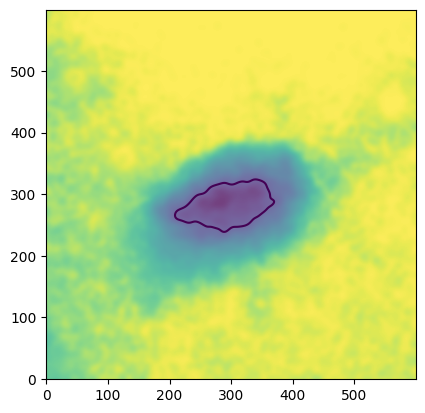

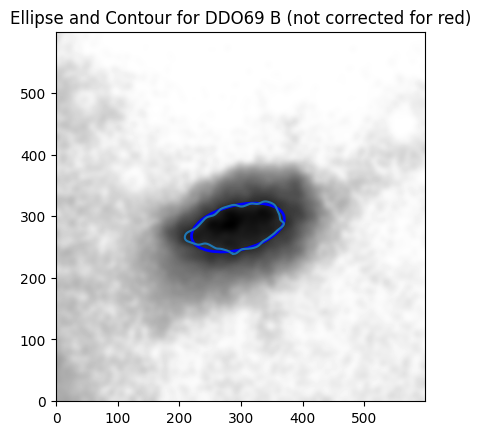

RB 25 for DDO69 is: 0.3387897360264195 kpc
Paper value is 0.30 kpc


In [ ]:
starless_file_u = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO69\non_shifted_background_d69u.fits")
starless_u = starless_file_u[0].data

starless_file_b = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO69\non_shifted_background_d69b.fits")
starless_b = starless_file_b[0].data

starless_file_v = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO69\non_shifted_background_d69v.fits")
starless_v = starless_file_v[0].data

DDO69 = [starless_u , starless_b , starless_v]
galaxy_name = "DDO69"
# Constants and parameters
pixel_scale = 1.134
D = 0.8
E_B_V = 0.00
filters = ["U", "B", "V"]
exposures = [1800, 2400, 1200]
airmass_values = [1.22, 1.04, 1.1]
mU_values = [5.251, 0.459, -0.121, 0]
mV_values = [3.009, 0.2183592, 0.0415, 0.]
mB_values = [3.434, 0.3398903, -0.0157, 0.]
m_values = [mU_values, mB_values, mV_values]

# Crop image to a specific region
box_size_x = 300
box_size_y = 300
box_center = (520, 430)
image_boxes = [DDO69[i][box_center[0] - box_size_y: box_center[0] + box_size_y, box_center[1] - box_size_x: box_center[1] + box_size_x] for i in range(len(DDO69))]

# Magnitude correction
b_box = ltf.mag_table_correction(image_boxes, airmass_values, m_values, pixel_scale, exposures, 5)[1]
v_box = ltf.mag_table_correction(image_boxes, airmass_values, m_values, pixel_scale, exposures, 5)[2]

# Contour coordinates
contour_points = ltf.contour_lines_coordinates(b_box, [25])
x_points, y_points = contour_points
# Center of mass for ellipse fitting

image_center_of_mass = ndimage.center_of_mass(b_box)
x, y = image_center_of_mass[1], image_center_of_mass[0]
initial_guess = [x, y, (max(x_points) - min(x_points)) / 2, (max(y_points) - min(y_points)) / 2, 0]

# Fit ellipse
popt_25, pcov_25 = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
xc, yc, a, b, theta = popt_25

# Plot the image, contour, and ellipse
fig, ax = plt.subplots()
ax.imshow(b_box, cmap='gray', origin='lower')
ax.plot(x_points, y_points)
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(ellipse)
plt.title("Ellipse and Contour for DDO69 B (not corrected for red)")
plt.show()

# Calculate the physical size
a_25_arcsec = a * pixel_scale
RB_25 = (D * a_25_arcsec) / 206265
print("RB 25 for DDO69 is:", RB_25 * 1000, "kpc")
print("Paper value is 0.30 kpc")


Median of the center box: 0.24422993453990216


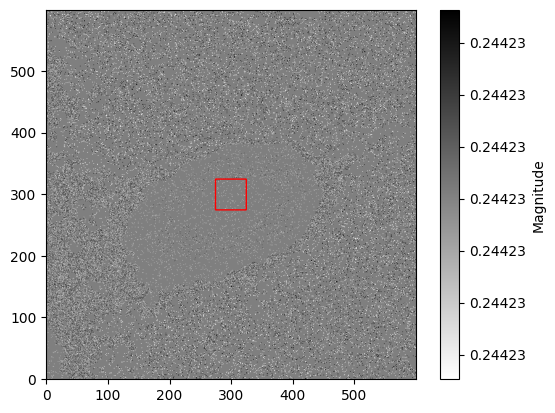

Holmberg mag threshold is 26.756390260246445


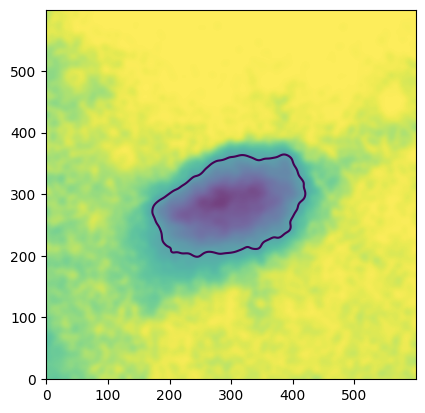

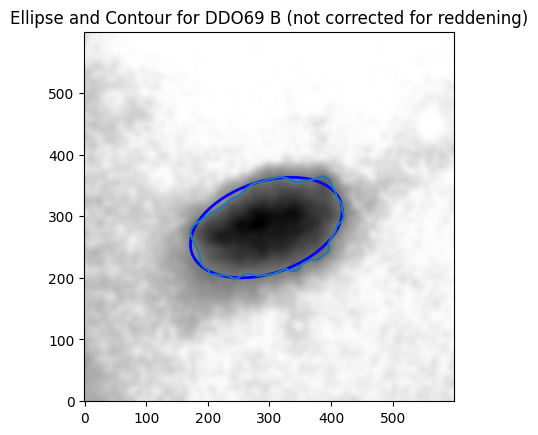

RH for DDO69 is: 0.561729771996861 kpc
Paper value is 0.56 kpc


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

B_V_magnitude_table = b_box - v_box

# Get the dimensions of the image
height, width = B_V_magnitude_table.shape

# Calculate the coordinates for the center box
center_x, center_y = width // 2, height // 2
box_size = 50

# Extract the center box
center_box = B_V_magnitude_table[center_y - box_size // 2:center_y + box_size // 2, center_x - box_size // 2:center_x + box_size // 2]

# Calculate the median of the center box
median_center_box = np.nanmedian(center_box)

print("Median of the center box:", median_center_box)

# Plot the image with the box
fig, ax = plt.subplots()
im = ax.imshow(B_V_magnitude_table, origin='lower', cmap='gray_r', vmin=np.nanmin(B_V_magnitude_table), vmax=np.nanmax(B_V_magnitude_table)) 
cbar = fig.colorbar(im, ax=ax, format='%.5f')
cbar.set_label('Magnitude')

# Add the box to the image
box_mask = np.zeros_like(B_V_magnitude_table, dtype=bool)
box_mask[center_y - box_size // 2:center_y + box_size // 2, center_x - box_size // 2:center_x + box_size // 2] = True
ax.contour(box_mask, colors='red', linewidths=1)

plt.show()


fig, ax = plt.subplots()

#Holmberg magnitude:
H = float(26.5 + 0.22 + 0.149*(median_center_box))
print(f"Holmberg mag threshold is {H}")

# Contour coordinates
contour_points_H = ltf.contour_lines_coordinates(b_box, [H])
x_points_H, y_points_H = contour_points_H
# Center of mass for ellipse fitting
image_center_of_mass = ndimage.center_of_mass(b_box)
x, y = image_center_of_mass[1], image_center_of_mass[0]
initial_guess = [x, y, (max(x_points_H) - min(x_points_H)) / 2, (max(y_points_H) - min(y_points_H)) / 2, 0]
# Fit ellipse
popt_25_H, pcov_25_H = curve_fit(ltf.ellipse, (x_points_H, y_points_H), np.zeros_like(x_points_H), p0=initial_guess)
xc_H, yc_H, a_H, b_H, theta_H = popt_25_H
# Plot the image, contour, and ellipse (not reddening corrected)
fig, ax = plt.subplots()
ax.imshow(b_box, cmap='gray', origin='lower')
ax.plot(x_points_H, y_points_H)
ellipse = Ellipse(xy=(xc, yc), width=2*a_H, height=2*b_H, angle=np.degrees(theta_H), edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(ellipse)
plt.title(f"Ellipse and Contour for {galaxy_name} B (not corrected for reddening)")
plt.show()
# Calculate the physical size
a_25_arcsec_H = a_H * pixel_scale
RH = (D * a_25_arcsec_H) / 206265
print(f"RH for {galaxy_name} is:", RH * 1000, "kpc")
print("Paper value is 0.56 kpc")


# DDO 101

## R_25

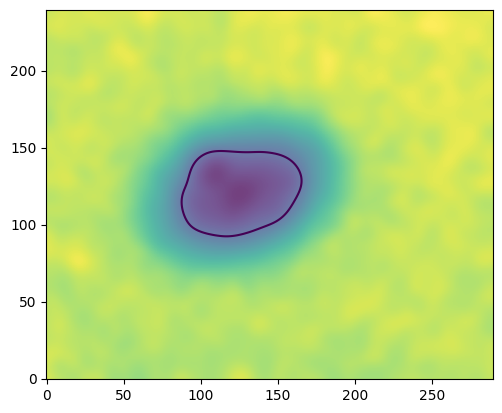

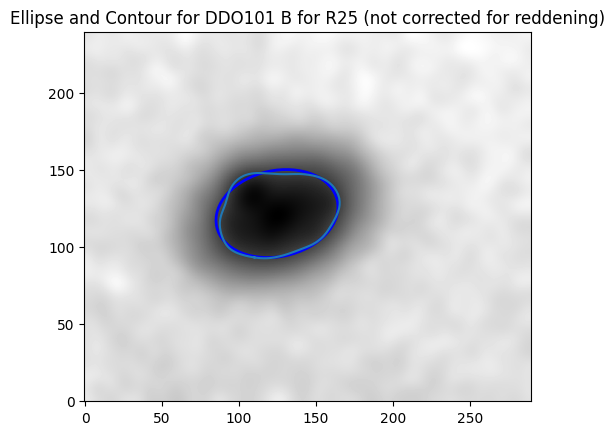

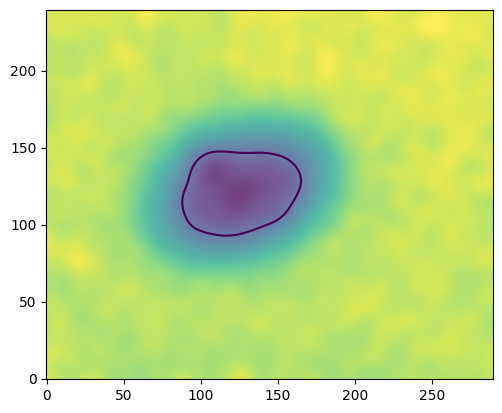

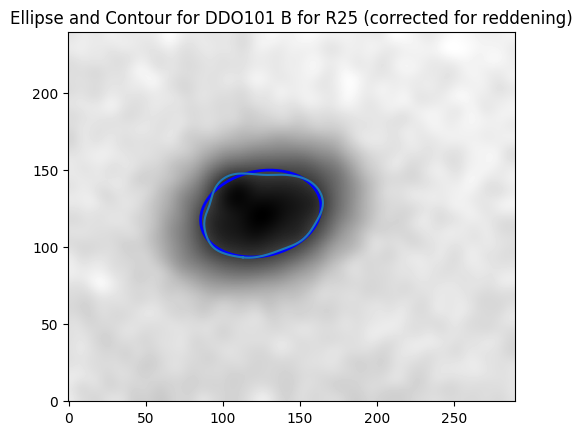

NOT corrected RB 25 for DDO101 is: 1.9818216200568466 kpc
CORRECTED RB 25 for DDO101 is: 1.9559754234607127 kpc
Paper value is 1.81 kpc


In [ ]:
starless_file_u = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO101\non_shifted_background_d101u.fits")
starless_u = starless_file_u[0].data

starless_file_b = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO101\non_shifted_background_d101b.fits")
starless_b = starless_file_b[0].data

starless_file_v = fits.open(r"C:\Users\AYSAN\Desktop\project\Galaxy\Starless images\DDO101\non_shifted_background_d101V.fits")
starless_v = starless_file_v[0].data

DDO101 = [starless_u , starless_b , starless_v]
galaxy_name = "DDO101"
# Constants and parameters
pixel_scale = 1.134
D = 9.0
E_B_V = 0.01
airmass_values=[1.03, 1.015, 1.09]
exposures = [1800, 1800, 1200]
mU_values = [5.065, 0.514, -0.146, 0.]
mB_values = [3.445, 0.2373955, -0.022, 0.]
mV_values = [3.017, 0.1283061, 0.045, 0.]
m_values = [mU_values,mB_values,mV_values]

box_size_x = 145
box_size_y = 120
box_center = [450,500]

image_boxes = []
for i in range(0 , len(DDO101)):
        box = DDO101[i][box_center[1] - box_size_y : box_center[1] + box_size_y, box_center[0] - box_size_x : box_center[0] + box_size_x]
        image_boxes.append(box)

#--------------------------------------------------------------------------------------------------------------------------------------------------#
# Magnitude correction
b_box = ltf.mag_table_correction(image_boxes, airmass_values, m_values, pixel_scale, exposures, 5)[1]
v_box = ltf.mag_table_correction(image_boxes, airmass_values, m_values, pixel_scale, exposures, 5)[2]
# Contour coordinates
contour_points = ltf.contour_lines_coordinates(b_box, [25])
x_points, y_points = contour_points
# Center of mass for ellipse fitting
image_center_of_mass = ndimage.center_of_mass(b_box)
x, y = image_center_of_mass[1], image_center_of_mass[0]
initial_guess = [x, y, (max(x_points) - min(x_points)) / 2, (max(y_points) - min(y_points)) / 2, 0]
# Fit ellipse
popt_25, pcov_25 = curve_fit(ltf.ellipse, (x_points, y_points), np.zeros_like(x_points), p0=initial_guess)
xc, yc, a, b, theta = popt_25
# Plot the image, contour, and ellipse (not reddening corrected)
fig, ax = plt.subplots()
ax.imshow(b_box, cmap='gray', origin='lower')
ax.plot(x_points, y_points)
ellipse = Ellipse(xy=(xc, yc), width=2*a, height=2*b, angle=np.degrees(theta), edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(ellipse)
plt.title(f"Ellipse and Contour for {galaxy_name} B for R25 (not corrected for reddening)")
plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------#
b_box_corrected = ltf.correct_reddening_B(b_box, E_B_V)
contour_points_c = ltf.contour_lines_coordinates(b_box_corrected, [25])
x_points_c, y_points_c = contour_points_c
# Center of mass for ellipse fitting
image_center_of_mass_c = ndimage.center_of_mass(b_box_corrected)
x, y = image_center_of_mass_c[1], image_center_of_mass_c[0]
initial_guess_c = [x, y, (max(x_points_c) - min(x_points_c)) / 2, (max(y_points_c) - min(y_points_c)) / 2, 0]
# Fit ellipse
popt_25_c, pcov_25_c = curve_fit(ltf.ellipse, (x_points_c, y_points_c), np.zeros_like(x_points_c), p0=initial_guess_c)
xc_c, yc_c, a_c, b_c, theta_c = popt_25_c
# Plot the image, contour, and ellipse (reddening corrected)
fig, ax = plt.subplots()
ax.imshow(b_box_corrected, cmap='gray', origin='lower')
ax.plot(x_points_c, y_points_c)
ellipse_c = Ellipse(xy=(xc, yc), width=2*a_c, height=2*b_c, angle=np.degrees(theta_c), edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(ellipse_c)
plt.title(f"Ellipse and Contour for {galaxy_name} B for R25 (corrected for reddening)")
plt.show() 

#-------------------------------------------------------------------------------------------------------------------------------------------------#
# Calculate the physical size
a_25_arcsec = a * pixel_scale
RB_25 = (D * a_25_arcsec) / 206265
print(f"NOT corrected RB 25 for {galaxy_name} is:", RB_25 * 1000, "kpc")
a_25_arcsec_c = a_c * pixel_scale
RB_25_c = (D * a_25_arcsec_c) / 206265
print(f"CORRECTED RB 25 for {galaxy_name} is:", RB_25_c * 1000, "kpc")
print("Paper value is 1.81 kpc")

## R_H

Median of the center box: -0.07900230746897051


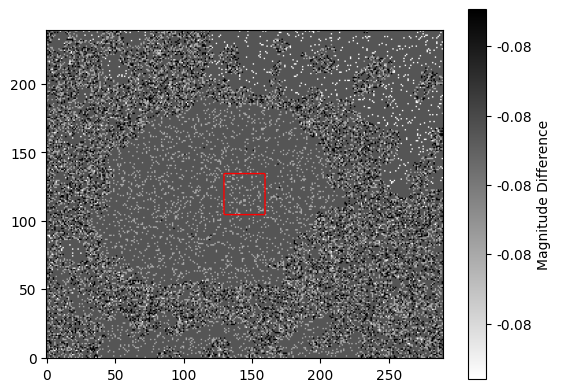

Holmberg mag threshold is 26.70822865618712


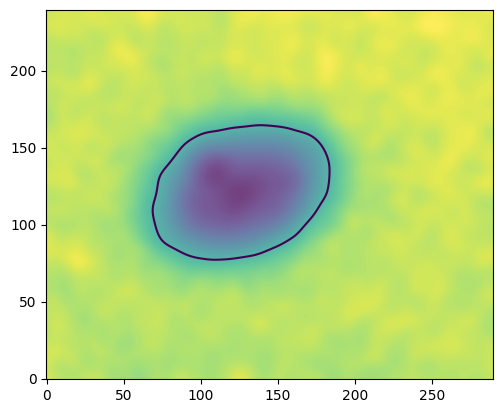

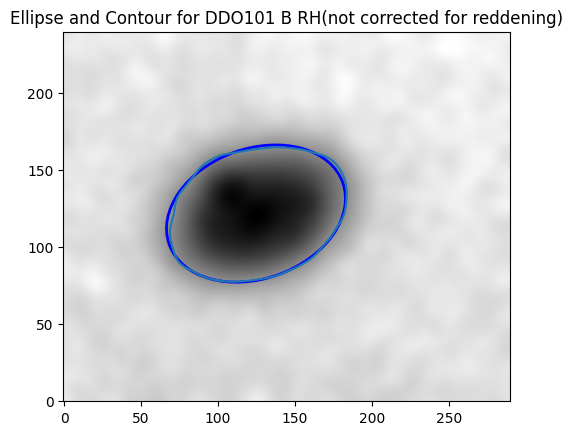

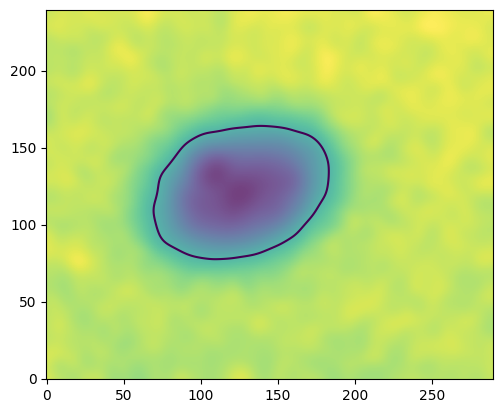

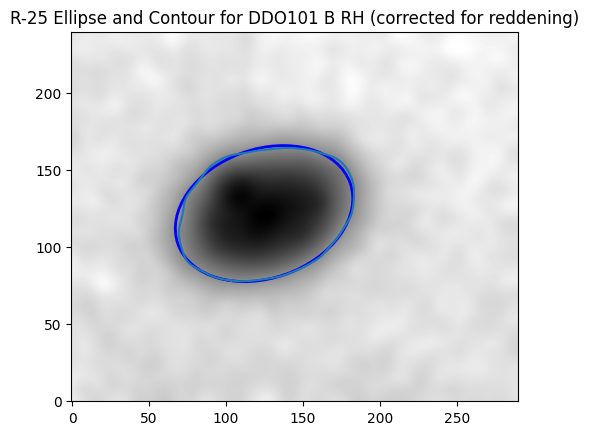

NOT corrected RH for DDO101 is: 2.959571255304675 kpc
CORRECTED RB 25 for DDO101 is: 2.9344969880762193 kpc
Paper value is 2.76 kpc


In [ ]:
B_V_magnitude_table = b_box - v_box - E_B_V

# Get the dimensions of the image
height, width = B_V_magnitude_table.shape

# Calculate the coordinates for the center box
center_x, center_y = width // 2, height // 2
box_size = 30

# Extract the center box
center_box = B_V_magnitude_table[center_y - box_size // 2:center_y + box_size // 2, center_x - box_size // 2:center_x + box_size // 2]

# Calculate the median of the center box
median_center_box = np.nanmedian(center_box)

print("Median of the center box:", median_center_box)

# Plot the image with the box
fig, ax = plt.subplots()
im = ax.imshow(B_V_magnitude_table, origin='lower', cmap='gray_r')  # Use inverted grayscale colormap
cbar = fig.colorbar(im, ax=ax, format='%.2f')
cbar.set_label('Magnitude Difference')

# Add the box to the image
box_mask = np.zeros_like(B_V_magnitude_table, dtype=bool)
box_mask[center_y - box_size // 2:center_y + box_size // 2, center_x - box_size // 2:center_x + box_size // 2] = True
ax.contour(box_mask, colors='red', linewidths=1)

plt.show()
#Holmberg magnitude:
H = float(26.5 + 0.22 + 0.149*(median_center_box))
print(f"Holmberg mag threshold is {H}")

# Contour coordinates
contour_points_H = ltf.contour_lines_coordinates(b_box, [H])
x_points_H, y_points_H = contour_points_H
# Center of mass for ellipse fitting
image_center_of_mass = ndimage.center_of_mass(b_box)
x, y = image_center_of_mass[1], image_center_of_mass[0]
initial_guess = [x, y, (max(x_points_H) - min(x_points_H)) / 2, (max(y_points_H) - min(y_points_H)) / 2, 0]
# Fit ellipse
popt_25_H, pcov_25_H = curve_fit(ltf.ellipse, (x_points_H, y_points_H), np.zeros_like(x_points_H), p0=initial_guess)
xc_H, yc_H, a_H, b_H, theta_H = popt_25_H
# Plot the image, contour, and ellipse (not reddening corrected)
fig, ax = plt.subplots()
ax.imshow(b_box, cmap='gray', origin='lower')
ax.plot(x_points_H, y_points_H)
ellipse = Ellipse(xy=(xc, yc), width=2*a_H, height=2*b_H, angle=np.degrees(theta_H), edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(ellipse)
plt.title(f"Ellipse and Contour for {galaxy_name} B RH(not corrected for reddening)")
plt.show()

#-------------------------------------------------------------------------------------------------------------------------------------------------#
b_box_corrected_H = ltf.correct_reddening_B(b_box, E_B_V)
contour_points_c_H = ltf.contour_lines_coordinates(b_box_corrected_H,[H])
x_points_c_H, y_points_c_H = contour_points_c_H
# Center of mass for ellipse fitting
image_center_of_mass_c = ndimage.center_of_mass(b_box_corrected_H)
x, y = image_center_of_mass_c[1], image_center_of_mass_c[0]
initial_guess_c_H = [x, y, (max(x_points_c_H) - min(x_points_c_H)) / 2, (max(y_points_c_H) - min(y_points_c_H)) / 2, 0]
# Fit ellipse
popt_25_c_H, pcov_25_c_H = curve_fit(ltf.ellipse, (x_points_c_H, y_points_c_H), np.zeros_like(x_points_c_H), p0=initial_guess_c_H)
xc_c_H, yc_c_H, a_c_H, b_c_H, theta_c_H = popt_25_c_H
# Plot the image, contour, and ellipse (reddening corrected)
fig, ax = plt.subplots()
ax.imshow(b_box_corrected_H, cmap='gray', origin='lower')
cax = ax.imshow(b_box_corrected_H, cmap='gray', origin='lower')
ax.plot(x_points_c_H, y_points_c_H)
ellipse_c_H = Ellipse(xy=(xc, yc), width=2*a_c_H, height=2*b_c_H, angle=np.degrees(theta_c_H), edgecolor='blue', facecolor='none', linewidth=2)
ax.add_patch(ellipse_c_H)
plt.title(f"R-25 Ellipse and Contour for {galaxy_name} B RH (corrected for reddening)")
plt.show() 

#-------------------------------------------------------------------------------------------------------------------------------------------------#
# Calculate the physical size
a_25_arcsec_H = a_H * pixel_scale
RH = (D * a_25_arcsec_H) / 206265
print(f"NOT corrected RH for {galaxy_name} is:", RH * 1000, "kpc")
a_25_arcsec_c_H = a_c_H * pixel_scale
RH_c = (D * a_25_arcsec_c_H) / 206265
print(f"CORRECTED RB 25 for {galaxy_name} is:", RH_c * 1000, "kpc")
print("Paper value is 2.76 kpc")